# Lending Club Analysis

#### Anuj Mehndiratta

##### Imports

In [211]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

## PART 1

##### Load Data

In [43]:
cols = ['loan_amnt', 
           'funded_amnt', 
           'term', 
           'int_rate', 
           'grade', 
           'annual_inc', 
           'issue_d', 
           'dti', 
           'revol_bal', 
           'total_pymnt', 
           'loan_status']
loan_data = pd.read_csv('loan.csv', parse_dates=True)
loan_data = loan_data[columns]
loan_data.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,1.00,1687.0,1008.710000,Charged Off
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,17.94,27783.0,3242.170000,Current


In [44]:
loan_data.shape

(887379, 11)

In [45]:
loan_data.dtypes

loan_amnt      float64
funded_amnt    float64
term            object
int_rate       float64
grade           object
annual_inc     float64
issue_d         object
dti            float64
revol_bal      float64
total_pymnt    float64
loan_status     object
dtype: object

In [46]:
pd.isnull(loan_data).mean()

loan_amnt      0.000000
funded_amnt    0.000000
term           0.000000
int_rate       0.000000
grade          0.000000
annual_inc     0.000005
issue_d        0.000000
dti            0.000000
revol_bal      0.000000
total_pymnt    0.000000
loan_status    0.000000
dtype: float64

It looks like the annual income is the only feature with any null values.

Adding a day value into the dates, so that I can convert them to pandas date time objects 

In [47]:
def add_day_value(date):
    return date[:3] + '-01' + date[3:]

loan_data['issue_d'] = loan_data['issue_d'].apply(add_day_value)
loan_data['issue_d'].head()

0    Dec-01-2011
1    Dec-01-2011
2    Dec-01-2011
3    Dec-01-2011
4    Dec-01-2011
Name: issue_d, dtype: object

Here I parse unique dates and then map them to their corresponding pandas date time object

In [48]:
unique_dates = loan_data['issue_d'].unique()
unique_pd_dates = pd.to_datetime(unique_dates)
date_map = dict(zip(unique_dates, unique_pd_dates))
loan_data['issue_d'] = loan_data['issue_d'].map(date_map)
loan_data['issue_d'].head()

0   2011-12-01
1   2011-12-01
2   2011-12-01
3   2011-12-01
4   2011-12-01
Name: issue_d, dtype: datetime64[ns]

I want to be able to deal with the terms of the loans as a quantitative feature. Extracting just the month from the values and converting to ints.

In [49]:
def extract_term(term):
    return int(term[:(term.index('m') - 1)])

unique_terms = loan_data['term'].unique()
unique_int_terms = np.vectorize(extract_term)(unique_terms)
term_map = dict(zip(unique_terms, unique_int_terms))
loan_data['term'] = loan_data['term'].map(term_map)
loan_data['term'].head()

0    36
1    60
2    36
3    36
4    60
Name: term, dtype: int64

#### Handle Null Values

In [51]:
loan_data.loc[loan_data['annual_inc'].isnull()]

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
42449,5000.0,5000.0,36,7.43,A,NaN,2007-08-01,1.0,0.0,5593.46,Does not meet the credit policy. Status:Fully ...
42450,7000.0,7000.0,36,7.75,A,NaN,2007-08-01,1.0,0.0,7867.53,Does not meet the credit policy. Status:Fully ...
42480,6700.0,6700.0,36,7.75,A,NaN,2007-07-01,1.0,0.0,7530.42,Does not meet the credit policy. Status:Fully ...
42533,6500.0,6500.0,36,8.38,A,NaN,2007-06-01,4.0,0.0,7373.83,Does not meet the credit policy. Status:Fully ...


In [52]:
loan_data['annual_inc'].describe()

count    8.873750e+05
mean     7.502759e+04
std      6.469830e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64

In [58]:
loan_data.loc[loan_data['annual_inc'].isnull()]['loan_status'].iloc[0]

'Does not meet the credit policy. Status:Fully Paid'

There are only four rows with null values. I checked to make sure that these are not actually meant to be 0's because there are other actual 0 values in the data. Therefore, I am comfortable just dropping the data. 

In [104]:
loan_data = loan_data.dropna()

#### Adding new features

I am going to add two features that I think may be interesting to look at. Percent funded will potentially tell me if there is any trend with the amounts that are funded. Loan as a percent of the annual income could potentially also provide some insight into the "requestor" of the loan.

In [64]:
loan_data['percent_funded'] = loan_data['funded_amnt']/loan_data['loan_amnt']

In [106]:
loan_data['loan_percent_of_income'] = loan_data['loan_amnt']/loan_data['annual_inc']

## Exploring features

In [50]:
loan_data['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

#### First finding and plot

In [108]:
loan_data.groupby('grade').median()

,loan_amnt,funded_amnt,term,int_rate,annual_inc,dti,revol_bal,total_pymnt,percent_funded,loan_percent_of_income
grade,,,,,,,,,,
A,12000.0,12000.0,36,7.26,75000.0,15.080,12867.0,4808.210,1.0,0.170958
B,12000.0,12000.0,36,10.99,65000.0,16.860,11879.0,4915.490,1.0,0.190476
C,12000.0,12000.0,36,13.99,60000.0,18.350,11563.0,4521.880,1.0,0.214286
D,14000.0,14000.0,36,16.99,60000.0,19.450,11304.0,5114.575,1.0,0.242061
E,16850.0,16800.0,60,19.99,61000.0,20.050,12155.0,5169.230,1.0,0.284211
F,18625.0,18550.0,60,23.76,65000.0,19.695,12022.5,6491.285,1.0,0.298707
G,20000.0,20000.0,60,25.83,68000.0,19.280,11553.0,8186.450,1.0,0.300000


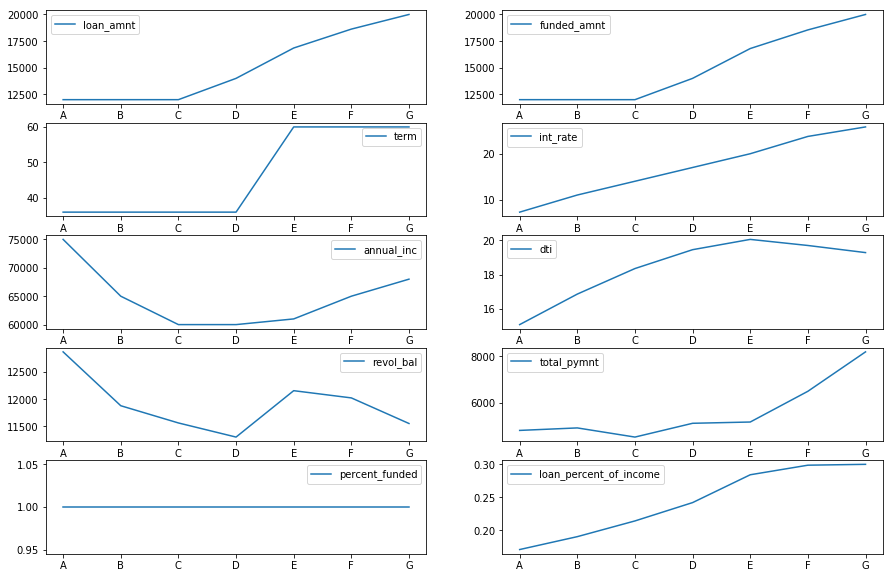

In [109]:
grouped_by_grade = loan_data.groupby('grade').median()
cols = grouped_by_grade.columns
fig, ax = plt.subplots(5, 2, figsize=(15,10))
for c, axis in zip(cols, ax.reshape(10,)):
    axis.plot(range(grouped_by_grade.shape[0]), grouped_by_grade[c], label=c)
    axis.set_xticklabels([' '] + list(grouped_by_grade.index.values))
    axis.legend()

In [215]:
scipy.stats.spearmanr(grouped_by_grade['loan_percent_of_income'])

SpearmanrResult(correlation=1.0, pvalue=0.0)

In [216]:
scipy.stats.spearmanr(grouped_by_grade['int_rate'])

SpearmanrResult(correlation=1.0, pvalue=0.0)

From the above plots and the spearman rank correlation, we can see that the loan percent of income as well as the interest rate are the only variables in our dataset that are strictly increasing/decreasing. However, the loan percent of income is the only variable that is independent with respect to the grade of the loan that is strictly increasing/decreasing.

#### Second finding and plot

Now lets take a look at the distributions of the loans that are fully paid and the ones that are not. We will try to see if there are any material differences.

In [110]:
paid_off_loans = loan_data.loc[loan_data['loan_status'] == 'Fully Paid']
late_or_default_loans = loan_data.loc[loan_data['loan_status'].isin(['Late (31-120 days)',
                                                                     'Late (16-30 days)',
                                                                     'Default'])]

In [113]:
paid_off_loans.mean()

loan_amnt                 13346.350910
funded_amnt               13306.858172
term                         40.638639
int_rate                     13.274244
annual_inc                74161.752983
dti                          16.139156
revol_bal                 15210.405063
total_pymnt               15186.680773
percent_funded                0.997854
loan_percent_of_income        0.201311
dtype: float64

In [114]:
late_or_default_loans.mean()

loan_amnt                 15554.882310
funded_amnt               15553.004879
term                         45.404101
int_rate                     15.968097
annual_inc                70264.521581
dti                          19.734772
revol_bal                 15468.360585
total_pymnt                6372.976256
percent_funded                0.999913
loan_percent_of_income        0.245687
dtype: float64

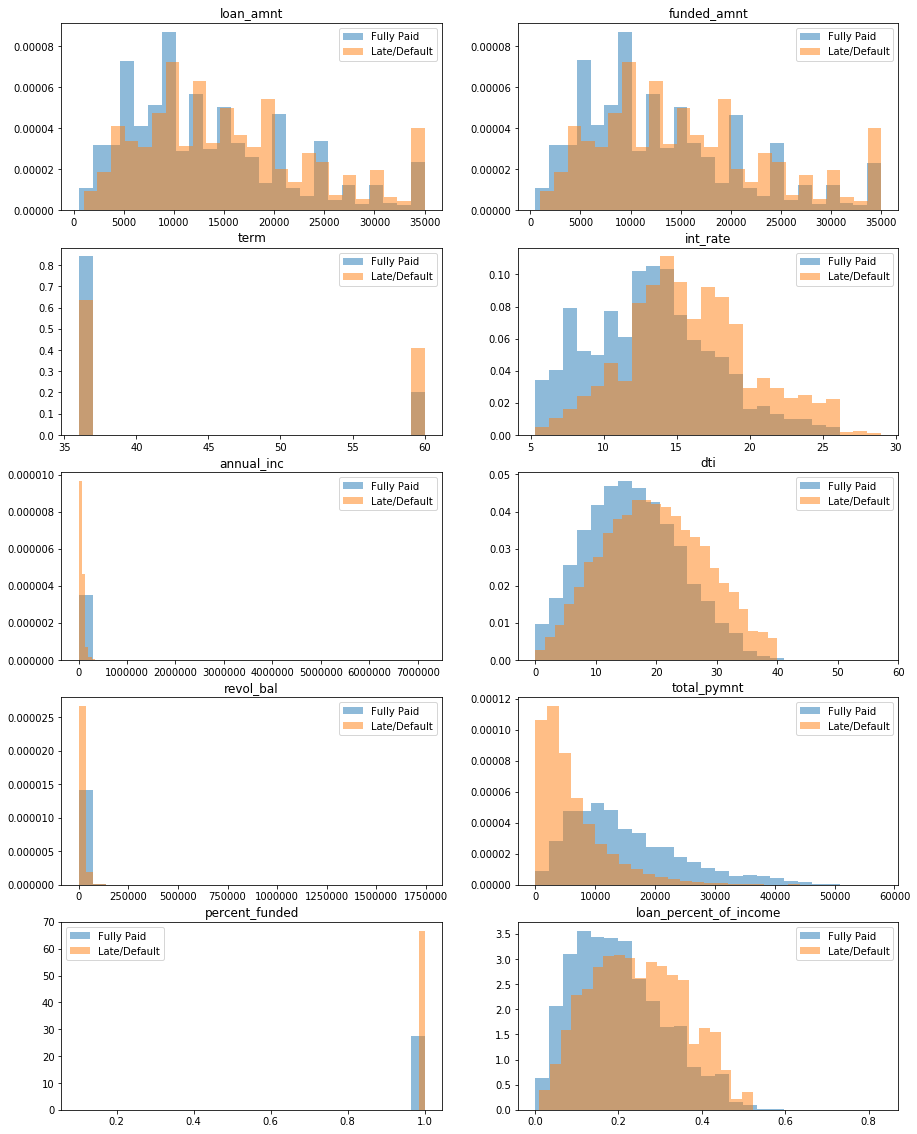

In [193]:
fig, ax = plt.subplots(5, 2, figsize=(15,20))
num_col = paid_off_loans.head().mean().index
for c, axis in zip(num_col, ax.reshape(10,)):
    axis.hist(paid_off_loans[c], bins=25, normed=True, alpha=.5, label= 'Fully Paid')
    axis.hist(late_or_default_loans[c], bins=25, normed=True, alpha=.5, label= 'Late/Default')
    axis.set_title(c)
    axis.legend()

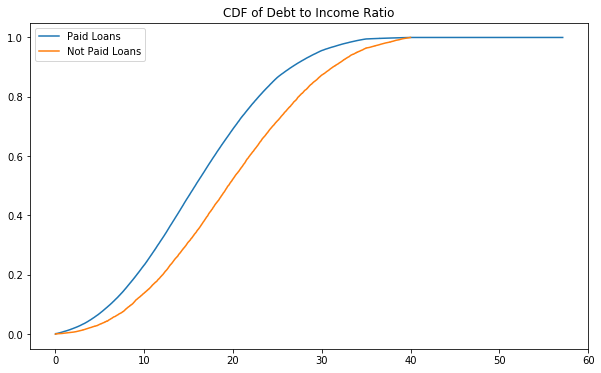

In [213]:
paid_dti = paid_off_loans['dti'].sort_values()
non_paid_dti = late_or_default_loans['dti'].sort_values()

def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

fig, ax = plt.subplots(figsize=(10,6))
paid_x, paid_y = ecdf(paid_dti)
non_paid_x, non_paid_y = ecdf(non_paid_dti)
ax.plot(paid_x, paid_y, label='Paid Loans')
ax.plot(non_paid_x, non_paid_y, label='Not Paid Loans')
ax.set_title('CDF of Debt to Income Ratio')
ax.legend();

In [214]:
scipy.stats.ks_2samp(paid_dti, non_paid_dti)

Ks_2sampResult(statistic=0.17088437781489613, pvalue=0.0)

Based on the above analysis of the distributions for paid loans versus not paid loans. I can conclude that they are not from the same distribution.

## PART 2

I am looking for all of the 36 month term loans that I have at least 36 months of data on. In order to do this I need to first locate all of the loans that have a 36 month issuing period. Next, I have to drop any current loans as I have yet to find the outcome of the loan. As a sanity check, I make sure that the max date in our subset of the data is at least 36 months prior to the max date in the original data.

In [147]:
loans_36 = loan_data[loan_data['term'] == 36]
last_date = loans_36[loans_36['loan_status'] == 'Current']['issue_d'].min()
loans_36 = loans_36[loans_36['issue_d'] < last_date]
loans_36.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status,percent_funded,loan_percent_of_income
0,5000.0,5000.0,36,10.65,B,24000.0,2011-12-01,27.65,13648.0,5861.071414,Fully Paid,1.0,0.208333
2,2400.0,2400.0,36,15.96,C,12252.0,2011-12-01,8.72,2956.0,3003.653644,Fully Paid,1.0,0.195886
3,10000.0,10000.0,36,13.49,C,49200.0,2011-12-01,20.00,5598.0,12226.302212,Fully Paid,1.0,0.203252
5,5000.0,5000.0,36,7.90,A,36000.0,2011-12-01,11.20,7963.0,5631.377753,Fully Paid,1.0,0.138889
7,3000.0,3000.0,36,18.64,E,48000.0,2011-12-01,5.35,8221.0,3938.144334,Fully Paid,1.0,0.062500


In [148]:
loans_36['issue_d'].max()

Timestamp('2012-11-01 00:00:00')

##### Question 1

In [150]:
loans_36['loan_status'].value_counts()/loans_36.shape[0]

Fully Paid                                             0.843282
Charged Off                                            0.121317
Does not meet the credit policy. Status:Fully Paid     0.025429
Does not meet the credit policy. Status:Charged Off    0.009246
Late (31-120 days)                                     0.000613
Default                                                0.000100
Late (16-30 days)                                      0.000014
Name: loan_status, dtype: float64

84% of the loans have been fully paid.

##### Question 2

In [153]:
loans_36['year'] = loans_36['issue_d'].dt.year
loans_36['year'].head()

0    2011
2    2011
3    2011
5    2011
7    2011
Name: year, dtype: int64

In [156]:
loans_36['defaulted'] = (loans_36['loan_status'] != 'Fully Paid')
loans_36.groupby(['year', 'grade'])['defaulted'].mean().idxmax()

(2007, 'G')

2007 loans that are grade G have the highest default rate.

##### Question 3

In [157]:
fully_paid_36 = loans_36[~loans_36['defaulted']]

In [173]:
def annualized_rate_return(row):
    total_pymnt = float(row['total_pymnt'])
    funded_amnt = float(row['funded_amnt'])
    return ((total_pymnt/funded_amnt) - 1.0)**(1.0/3)

fully_paid_36['funded_amnt'] = fully_paid_36['funded_amnt'] + 0.0001
fully_paid_36['ann_return'] = fully_paid_36.apply(annualized_rate_return, axis=1)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [174]:
fully_paid_36.groupby(['year', 'grade'])['ann_return'].mean().unstack('grade')

grade,A,B,C,D,E,F,G
year,,,,,,,
2007,0.446894,0.506901,0.534307,0.556568,0.585440,0.559132,NaN
2008,0.468094,0.518281,0.547020,0.581443,0.595186,0.644838,0.671471
2009,0.478605,0.531018,0.564607,0.587942,0.612660,0.608160,0.621076
2010,0.445555,0.518006,0.563983,0.593180,0.611695,0.628146,0.671977
2011,0.445568,0.522815,0.567758,0.597002,0.632154,0.639588,0.683785
2012,0.459247,0.544367,0.583836,0.622803,0.654422,0.658524,0.691859


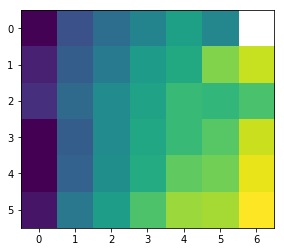

In [217]:
plt.imshow(fully_paid_36.groupby(['year', 'grade'])['ann_return'].mean().unstack('grade'));

The above matrix lists the annualized returns for each loan grouped by year and grade. I have also included a visualization to represent the findings.